In [1]:
!pip install torch

In [5]:
import torch
import torch.nn as nn
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [6]:
save_dir = "diffusion training data/"
#save_dir = '/content/drive/MyDrive/ai ai pong/'+ save_dir
def load_transitions():
    import os.path
    if not os.path.isfile(save_dir + "observations.npz"):
        print("No saved transitions found")
        return()
    #its stored as a dict so grab out the single array. and 0th axis should be the number of transitions
    observations = np.load(save_dir + "observations.npz")["arr_0"]
    actions = np.load(save_dir + "actions.npz")["arr_0"]
    rewards = np.load(save_dir + "rewards.npz")["arr_0"]
    dones = np.load(save_dir + "dones.npz")["arr_0"]
    assert(len(observations) == len(actions) == len(rewards) == len(dones))
    print("loaded transitions of length", len(observations))


    return observations, actions, rewards, dones

In [7]:
observations, actions, rewards, dones = load_transitions()
print(observations[0].size, actions[0].size, rewards[0].size, dones[0].size)

loaded transitions of length 15280
33600 1 1 1


In [8]:
#data too big, try smaller amount
n = 100#len(observations)#100 #number of observations to use.
#change bool in dones to floats
for i in range(len(dones)):
    dones[i] = dones[i].astype(float)


#create lists to organize the training data.
inputs = []
truths = []

h = observations[0].shape[0] #height of a pong image
w = observations[0].shape[1] #width of a pong image

vector_length = observations[i].shape[1]

#take 2 images as input, return one image (the model should need two input images to determine ball velocity)
for i in range(min(len(observations)-2,n)):
    #expand action to a matrix the size of a pong image, and add it as a seperate channel in a tensor image later
    act = np.broadcast_to(actions[i+1], (h,w) )
    rew = rewards[i+2]
    don = dones[i+2]


    input = np.stack((observations[i], observations[i+1], act), axis=0) #put the channels together so my life is easier and the nn pays a lot of attention to act
    truth = (observations[i+2],rew,don) #tuple of outputs
    inputs.append(input)
    truths.append(truth)



inputs = inputs[:n]
truths = truths[:n]

inputs = np.stack(inputs,axis=0) # shape of (n,3,h,w)
truths = (
    np.expand_dims(np.stack([t[0] for t in truths],axis = 0), axis=1),#(n,1,h,w)
    np.fromiter((t[1] for t in truths),dtype="float"),#(n)
    np.fromiter((t[2] for t in truths),dtype="float")#(n)
)

print(inputs.shape) # (n,3,h,w)
print(truths[0].shape) # (n,1,h,w)
print(truths[1].shape) # (n,)
print(truths[2].shape) # (n,)

inputs = torch.tensor(inputs,device=device,dtype=torch.float)
truths = (
    torch.tensor(truths[0],device=device,dtype=torch.float),
    torch.tensor(truths[1],device=device,dtype=torch.float),
    torch.tensor(truths[2],device=device,dtype=torch.float)
)

(100, 3, 210, 160)
(100, 1, 210, 160)
(100,)
(100,)


In [9]:

class Net(nn.Module):
    def __init__(self, hidden_channels):
        super(Net, self).__init__()
        #input of (N, 3, H, W), output of (N, hidden_size, H, W)
        self.encoder = nn.Sequential( 
            nn.Conv2d(in_channels = 3, out_channels=hidden_channels, kernel_size = 10, stride = 10, padding = 0,device=device),
            nn.ReLU(),
        )
        #input of (N, hidden_channels, H, W), output of (N, 3, ?,?)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=hidden_channels, out_channels=3, kernel_size=10, stride=10, padding=0,device=device), #see https://towardsdatascience.com/understand-transposed-convolutions-and-build-your-own-transposed-convolution-layer-from-scratch-4f5d97b2967
            nn.ReLU()
        )

    def forward(self, x):
        #assert x.device == self.device
        x = self.encoder(x)
        print(x)
        x = self.decoder(x)
        channels = torch.split(x,[1,1,1], dim=1) #split into the 3 channels
        image = channels[0] #(n,1,H,W)
        rew = torch.mean(channels[1],dim=(1,2,3)) #(n,)
        don = torch.mean(channels[2],dim=(1,2,3)) #(n,)
        return image,rew,don


In [73]:
hidden_channels = 20

# Create an instance of the network
net = Net(
    hidden_channels=hidden_channels,
    ).to(device)

In [63]:
#see https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

# define loss function and optimizer
import torch.optim as optim

img_criterion = nn.MSELoss()
rew_criterion = nn.MSELoss()
don_criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)


image_importance = 10 #hyperparameter for weighting how important the image is in the loss function.


In [66]:

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    # get the inputs; data is a list of [inputs, labels]

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    img,r,d = net(inputs)
    loss1 = img_criterion(img,truths[0])
    loss2 = rew_criterion(r,truths[1])
    loss3 = don_criterion(d,truths[2])
    loss = loss1#(image_importance * loss1) + loss2 + loss3
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 2000 == 1999:    # print every 2000 mini-batches
        print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
        running_loss = 0.0

print('Finished Training')

tensor([[[[ 14.9229,  13.0288,  13.0288,  ...,  13.0288,  13.0288,  13.0288],
          [ 13.0288,  13.0288,  13.0288,  ...,  13.0288,  13.0288,  13.0288],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          ...,
          [ 13.0288,  13.0288,  13.0288,  ...,  13.0288,  13.0288,  13.0288],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [ 36.2926,  36.2926,  36.2926,  ...,  36.2926,  36.2926,  36.2926]],

         [[ 26.2386,  29.7812,  29.7812,  ...,  29.7812,  29.7812,  29.7812],
          [ 29.7812,  29.7812,  29.7812,  ...,  29.7812,  29.7812,  29.7812],
          [ 66.5491,  66.5491,  66.5491,  ...,  66.5491,  66.5491,  66.5491],
          ...,
          [ 29.7812,  29.7812,  29.7812,  ...,  29.7812,  29.7812,  29.7812],
          [ 66.5491,  66.5491,  66.5491,  ...,  66.5491,  66.5491,  66.5491],
          [ 79.5602,  79.5602,  79.5602,  ...,  79.5602,  79.5602,  79.5602]],

         [[  0.0000,   0.0000,

In [ ]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from os import listdir
from os.path import isfile, join

class PongDataset(Dataset):
    def __init__(self, dir):
        self.dir = dir
    def __len__(self):
        existing_files = [f for f in listdir(self.dir) if isfile(join(self.dir, f))]
        if existing_files:
            #This grabs the largest integer out of all the filenames (filter the string for digit chars, convert those chars to an int)
            i = max(*[int(''.join([i for i in f if i.isdigit()])) for f in existing_files])
            return i
        else:
            return 0
    def __getitem__(self, index) -> Any:
        
        return super().__getitem__(index)

In [ ]:
# from torch.utils.data import Dataset
# from torchvision import datasets
# from torchvision.transforms import ToTensor
# #see https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
# class CustomImageDataset(Dataset):
#     def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
#         # self.img_labels = pd.read_csv(annotations_file)
#         # self.img_dir = img_dir
#         self.img_labels = data[1]
#         self.transform = transform
#         self.target_transform = target_transform

#     def __len__(self):
#         return len(self.img_labels)

#     def __getitem__(self, idx):
#         print(idx)
#         # img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
#         image = data[0]
#         label = data[1]
#         # if self.transform:
#         #     image = self.transform(image)
#         # if self.target_transform:
#         #     label = self.target_transform(label)
#         return image, label


# batch_size = 64
# trainset = CustomImageDataset("","")
# if __name__ == '__main__':
#     trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)#, num_workers=1)

In [68]:

# for epoch in range(1):  # loop over the dataset multiple times #todo why does multiple times break it?

#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#         print(i)
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = net(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % 2000 == 1999:    # print every 2000 mini-batches
#             print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
#             running_loss = 0.0

# print('Finished Training')

In [69]:
PATH = './models/pong_gen.pth'
torch.save(net.state_dict(), PATH)

In [70]:
net = Net(hidden_channels=hidden_channels)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [74]:
output = net(inputs[0].unsqueeze(0))[0]
print(output.shape)

tensor([[[[  7.7892,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  8.2228,   8.2228,   8.2228,  ...,   8.2228,   8.2228,   8.2228],
          ...,
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  8.2228,   8.2228,   8.2228,  ...,   8.2228,   8.2228,   8.2228],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],

         [[  2.8819,  13.6867,  13.6867,  ...,  13.6867,  13.6867,  13.6867],
          [ 13.6867,  13.6867,  13.6867,  ...,  13.6867,  13.6867,  13.6867],
          [ 27.8106,  27.8106,  27.8106,  ...,  27.8106,  27.8106,  27.8106],
          ...,
          [ 13.6867,  13.6867,  13.6867,  ...,  13.6867,  13.6867,  13.6867],
          [ 27.8106,  27.8106,  27.8106,  ...,  27.8106,  27.8106,  27.8106],
          [ 37.0464,  37.0464,  37.0464,  ...,  37.0464,  37.0464,  37.0464]],

         [[  0.0000,   0.0000,

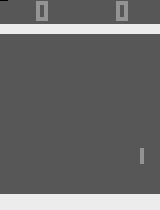

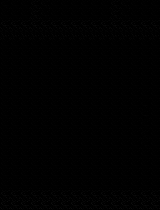

[[ 0.09021153  0.          2.2327597  ...  0.          1.8028812
   3.4539077 ]
 [ 0.          0.5382179   0.         ...  5.263327    0.
   0.        ]
 [ 0.          3.3512206   2.03043    ...  0.          0.3735533
   0.        ]
 ...
 [ 9.836808    0.          0.         ...  0.          0.
   0.9972122 ]
 [ 0.         15.749324    0.         ...  6.148968    0.
  13.59721   ]
 [ 0.70889044  0.          5.2335167  ...  2.0777683   0.2534162
   0.        ]]


In [78]:
from PIL import Image
image = Image.fromarray(observations[2])# true value
image.show()

image = Image.fromarray(output[0][0].detach().numpy())# predicted value
image.show()
print(output[0][0].detach().numpy())

In [ ]:
gif = []
images = [Image.fromarray(observation) for observation in observations]
for image in images:
    gif.append(image)
gif[0].save('temp/result.gif', save_all=True,optimize=False, append_images=gif[1:], loop=0)